# SD211 TP - Régression logistique

<p>Autheur: Rui SONG</p>
<p>Date : 12 mai 2017</p>

## Imports et initialisations

In [115]:
import numpy as np
from scipy.optimize import check_grad
import scipy
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report

## 1. Régularisation de Tikhonov

### Question 1.1 Calcul du gradient et de la matrice hessienne

<p>La fonction d'objectif est: 
$$f_{1}(w_{0}, \mathbf{w)} = \frac{1}{n}\sum_{i=1}^{n}log(1 + exp(-y_{i}(\mathbf{x_{i}}^{T}\mathbf{w} + w_{0}))) + \frac{\rho}{2}\lVert\mathbf{w}\rVert_{2}^{2}$$</p>

<p>Notons $\widetilde{\mathbf{w}} = (w_{0},w^T)^{T}$ , $\tilde{\mathbf{x_{i}}} = (1, \mathbf{x_{i}}^{T})^{T}$, et une matrice diagonale de taile $(m+1)\times(m+1)$ :
$$M = \begin{pmatrix}
0&0&\cdots&0\\
0&1&\ddots&\vdots\\
\vdots&\ddots&\ddots&0&\\
0&\cdots&0&1
\end{pmatrix}$$
alors la fonctino d'objectif devient:

$$f_{1}(\widetilde{\mathbf{w}}) = \frac{1}{n}\sum_{i=1}^{n}log(1 + exp(-y_{i}\tilde{\mathbf{x_{i}}}^{T}\widetilde{\mathbf{w}})) + \frac{\rho}{2}\lVert M\widetilde{\mathbf{w}}\rVert_{2}^{2}$$</p>

<p>Alors, on a le gradient de $f_{1}:$

$$\bigtriangledown f_{1} = \frac{1}{n}\sum_{i=1}^{n}\frac{-y_{i}\tilde{\mathbf{x_{i}}}}{1 + exp(y_{i}\tilde{\mathbf{x_{i}}}\widetilde{\mathbf{w}})} + \rho M\widetilde{\mathbf{w}}$$</p>

<p>La matrice hessienne de la fonction d'objectif est:

$$H(\widetilde{\mathbf{w}}) = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}exp(y_{i}\tilde{\mathbf{x_{i}}}\widetilde{\mathbf{w}})}{[1 + exp(y_{i}\tilde{\mathbf{x_{i}}}\widetilde{\mathbf{w}})]^{2}}\cdot \tilde{\mathbf{x_{i}}}\tilde{\mathbf{x_{i}}}^{T} + \rho M$$ 
</p>
<p>La matrice hessienne est définie positive, donc la fonction d'objectif est convexe.</p>

### Question 1.2

In [2]:
def load_cervical_cancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'riskfactorscervicalcancer.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, 
        il y a un fort risque de cancer du col de l'uterus, 
        et si y[i] = -1, les tests sont negatifs

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#
    """

    data = np.loadtxt(filename, delimiter=',', skiprows=1)

    # predire si un des tests est positif
    y = np.max(data[:, -4:], axis=1) * 2 - 1
    # reequilibrer la base de donnees 
    pos_indices = np.where(y > 0)[0]
    neg_indices = np.where(y < 0)[0]
    indices = pos_indices.tolist() + neg_indices[1::7].tolist()

    y = y[indices]
    X = data[indices, :-4]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X = X[:, std_ > 0]
    std_ = std_[std_ > 0]
    X = X / std_

    return X, y

print "Data loading..."
X, y = load_cervical_cancer("riskfactorscervicalcancer.csv")
print X.shape, y.shape

Data loading...
(210, 26) (210,)


In [3]:
n, m = X.shape
rho = 1.0/n

In [4]:
ones = np.ones((n))
X_ = np.column_stack((ones, X))
#print X_[1, :].shape

def objective_total(omega, X, y, rho):
    omega = omega.reshape(-1)
    n, m = X.shape
    M = np.diag(np.ones(m))
    M[0,0] = 0
    
    val = 0
    grad = np.zeros_like(omega)
    hessienne = np.zeros((m, m))
    for i in range(n):
        xi = X[i,:]
        yi = y[i]
        xomega = xi.dot(omega)
        log = np.log(1 + np.exp(-yi*xomega))
        val = val + log
        exp = np.exp(yi*xomega)
        coef = -yi / (1 + exp)
        grad = grad + coef * xi
        coefH = -coef*yi*exp / (1 + exp)
        xi_ = xi.reshape(m,-1)
        hessienne = hessienne + coefH*xi_.dot(xi_.T)
    val = val/n + rho*(np.sum(omega[1:] ** 2))/2
    grad = grad/n + rho*M.dot(omega)
    hessienne = hessienne/n + rho*M
    return val, grad, hessienne

def func(omega, X, y, rho):
    val, grad, hessienne = objective_total(omega, X, y, rho)
    return val

def grad(omega, X, y, rho):
    val, grad, hessienne = objective_total(omega, X, y, rho)
    return grad

def grad_func(omega, X, y, rho):
    val, grad, hessienne = objective_total(omega, X, y, rho)
    return grad.sum()

def hess(omega, X, y, rho):
    val, grad, hessienne = objective_total(omega, X, y, rho)
    return np.sum(hessienne, axis = 1)

print "Checking the correctness of gradient..."
print check_grad(func, grad, np.zeros_like(X_[1, :]),X_,y,rho)
print "Checking the correctness of hessian matrice..."
print check_grad(grad_func, hess, np.zeros_like(X_[1, :]),X_,y,rho)

print grad(np.zeros_like(X_[1, :]),X_,y,rho).shape

Checking the correctness of gradient...
5.89146026209e-07
Checking the correctness of hessian matrice...
7.67679640751e-07
(27,)


### Question 1.3  Méthode de Newton

Pour l'itération $k$, le mis-à-jour de $\widetilde{\mathbf{w}}_{k}$ est:
$$\widetilde{\mathbf{w}}_{k} = \widetilde{\mathbf{w}}_{k-1} - H(\widetilde{\mathbf{w}})^{-1}\bigtriangledown f_{1}$$

In [5]:
def Newton(g, omega0, X, y, rho, tolerance = 1e-10):
    val, grad, hessienne = g(omega0, X, y, rho)
    norm = np.sqrt(np.sum(grad[1:] ** 2))
    grad_norm = [norm]
    k = 0
    while(norm > tolerance):
        omega0 = omega0 - scipy.linalg.solve(hessienne, grad)
        val, grad, hessienne = g(omega0, X, y, rho)
        norm = np.sqrt(np.sum(grad[1:] ** 2))
        grad_norm.append(norm)
        k = k + 1
    return val, grad_norm, omega0, k

val, grad_norm, sol, k = Newton(objective_total, np.zeros_like(X_[1, :]), X_, y, rho, 1e-10)
print "The value of the objective function is %f" %val

The value of the objective function is 0.564491


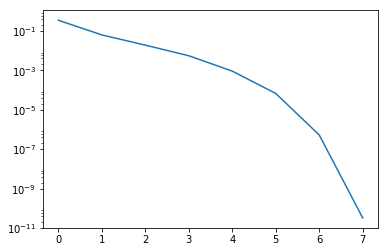

In [6]:
fig = plt.figure(1)
plt.semilogy(grad_norm)
plt.show()

### Question 1.4

In [7]:
val, grad_norm, sol, k = Newton(objective_total, 0.3*np.ones_like(X_[1, :]), X_, y, rho, 1e-10)

/Users/rui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in exp
/Users/rui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/rui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in exp


ValueError: array must not contain infs or NaNs

En lançant comme la condition initiale $(w_{0}^{0}, \mathbf{w^{0}}) = 0.3e$, on a rencontré le problème de 'overflow'.

### Question 1.5

In [123]:
n, m = X.shape
rho = 1.0/n
def Newton_armijo(g, omega0, X, y, rho, tolerance = 1e-10, max_iter = 1e2):
    a = 0.5
    b = 1
    beta = 0.5
    
    val, grad, H = g(omega0, X, y, rho)
    dw = np.linalg.solve(H, grad)
    norm = np.sqrt(np.sum(grad ** 2))
    grad_norm = [norm]
    
    k = 0
    while((norm > tolerance) and (k <= max_iter)):
        #print "val: %f" %val
        gamma = b
        omegak = omega0 - gamma*dw
        valk, gradk, Hk= g(omegak, X, y, rho)
        while(valk > val-beta*gamma*np.sum(grad*dw)):
            gamma = gamma * a
            omegak = omega0 - gamma*dw
            valk, gradk, Hk = g(omegak, X, y, rho)
            #print "valk: %f" %valk
        omega0 = omegak
        val, grad, H = g(omega0, X, y, rho)
        dw = np.linalg.solve(H, grad)
        norm = np.sqrt(np.sum(grad ** 2))
        grad_norm.append(norm)
        b = 2 * gamma
        k = k + 1
    return val, grad_norm, omega0, k

time1 = time.time()
val, grad_norm, sol_l2, k = Newton_armijo(objective_total, 0.3*np.ones_like(X_[1, :]), X_, y, rho, 1e-10)
time2 = time.time()
print val
print sol_l2
print "Times of iterations: %d" %k
print "Time used : %f" %(time2 - time1)

0.564490766022
[ 0.2013495  -0.17213872 -0.04798368 -0.14852973  0.17226181 -0.00720006
  0.20673756 -0.03692106  0.0768277   0.43086559  0.12956021  0.17260728
  0.31592059  0.17684201  0.10474188  0.10474188 -0.39105042  0.1639398
  0.66262584 -0.33199982  0.64063084 -0.39451384 -0.39515206  0.3884854
  0.02848865  0.3884854   0.27776305]
Times of iterations: 11
Time used : 0.114897


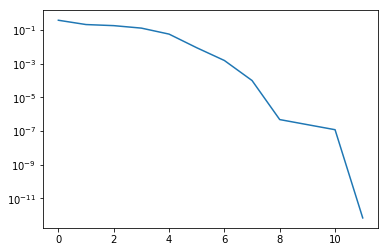

1.20382424965e-07 6.87271773821e-13


In [124]:
fig = plt.figure(2)
plt.semilogy(grad_norm)
#plt.ylim([1e-11, 2e-1])
plt.show()
print grad_norm[-2], grad_norm[-1]

<p>Au fait que l'algorithme armijo est un algorithme d'approximation, si l'on choisir un trop petite valeur de paramètre d'arrêt 'tolerance', l'algorithme peut continuer à excuter beaucoup d'itérations. Donc, on a ajouter un autre paramètre 'max_iter', l'algorithme va s'arrêter après 'max_iter' d'itérations.</p>
<p>Quant aux paramètre de l'algorithme ($a$, $b$, et $\beta$), les choix classique, c'est: $a = 0.5, b = 2\gamma_{k-1}, \beta = 0.5$</p>

## 2. Régularisation pour la parcimonie

### Question 2.1

On ne peut pas utiliser la méthode de Newton pour résoudre ce problème parce que la fonction d'objectif n'est pas dérivable. 

### Question 2.2

Notons $\widetilde{\mathbf{w}}$ , $\tilde{\mathbf{x_{i}}}$ et $M$ comme dans la Question 1.1, la fonction objectif $F_{2}$ est :
$$F_{2}(\widetilde{\mathbf{w}}) = \frac{1}{n}\sum_{i=1}^{n}log(1 + exp(-y_{i}\tilde{\mathbf{x_{i}}}^{T}\widetilde{\mathbf{w}})) + \rho\lVert \mathbf{w}\rVert_{1}$$

Alors $f_{2}$ et $g_{2} sont:$
$$f_{2} = \frac{1}{n}\sum_{i=1}^{n}log(1 + exp(-y_{i}\tilde{\mathbf{x_{i}}}^{T}\widetilde{\mathbf{w}}))$$
$$g_{2} = \rho\lVert \mathbf{w}\rVert_{1}$$

L'opérateur proximal de $g_{2}$ est:
$$prox_{\rho|·|}(\mathbf{w}) = S_{\rho}(\mathbf{w}),$$ 
où $S_{\rho}(\mathbf{w}) = (S_{\rho}(w_{0}), S_{\rho}(w_{1}),...,S_{\rho}(w_{m}))$ et $S_{\rho}(w_{i})$ est le seuillage doux: 
$$S_{\rho}(w_{i})=
\begin{cases}
w_{i} - \rho& \text{$w_{i} - \rho > 0$}\\
w_{i} + \rho& \text{$w_{i} + \rho < 0$}\\
0& \text{$w_{i} \in [-\rho, \rho]$}
\end{cases}$$

Le gradient de $f_{2}$ est:
$$\bigtriangledown f_{2} = \frac{1}{n}\sum_{i=1}^{n}\frac{-y_{i}\tilde{\mathbf{x_{i}}}}{1 + exp(y_{i}\tilde{\mathbf{x_{i}}}\widetilde{\mathbf{w}})}$$

La fonction d'objective est convexe parce que c'est la somme de deux fonction convexe.

### Question 2.3 

Ci-dessous, c'est le code de l'algorithme du gradient proximal avec recherche linéaire. Ici on utilise recherche linénaire basé sur Taylor au lieu de Armijo, parce que les résultats obtenues par Armijo ne seront pas le même quand la condition initiale est différente.

In [97]:
def objective_total2(omega, X, y, rho):
    omega = omega.reshape(-1)
    n, m = X.shape
    
    val = 0
    grad = np.zeros_like(omega)
    hessienne = np.zeros((m, m))
    for i in range(1, n):
        xi = X[i,:]
        yi = y[i]
        xomega = xi.dot(omega)
        log = np.log(1 + np.exp(-yi*xomega))
        val = val + log
        exp = np.exp(yi*xomega)
        coef = -yi / (1 + exp)
        grad = grad + coef * xi
    val = val/n #+ rho * np.sum(np.absolute(omega))
    grad = grad/n
    valF = val + rho * np.sum(np.fabs(omega))
    return val, grad, valF

In [125]:
def softThred(omega, rho):
    somega = np.zeros_like(omega)
    somega[omega > rho] = omega[omega > rho] - rho
    somega[omega < -rho] = omega[omega < -rho] + rho
    somega[0] = omega[0]
    return somega

def proximal(g, omega0, X, y, rho, tolerance = 1e-10, max_iter = 1e2):
    a = 0.5
    b = 1
    
    val, grad, valF= g(omega0, X, y, rho)

    diff = tolerance + 1
    k = 0
    while((diff > tolerance) and (k <= max_iter)):
        gamma = b
        omegak = softThred(omega0 - gamma*grad, gamma*rho)
        valk, gradk, valFk = g(omegak, X, y, rho)
        while(valk > val+np.sum(grad*(omegak - omega0)) + np.sum((omega0 - omegak)**2)/(2*gamma)):
            gamma = gamma * a
            omegak = softThred(omega0 - gamma*grad, gamma*rho)
            valk, gradk, valFk = g(omegak, X, y, rho)
        diff = valF - valFk
        omega0 = omegak
        val, grad, valF = g(omega0, X, y, rho)
        b = 2 * gamma
        k = k + 1
        #print "difference"
        #print diff
    return valF, omega0, k

rho = 0.1
time1 = time.time()
val, sol_l1, k = proximal(objective_total2, 0.3*np.ones_like(X_[1, :]), X_, y, rho, 1e-10)
time2 = time.time()
print val
print sol_l1
print "Times of iterations: %d" %k
print "Time used: %f" %(time2 - time1)

0.692123039108
[-0.02853739  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.00186666
  0.00772562  0.          0.          0.          0.          0.          0.
  0.00798815  0.          0.          0.01895785  0.          0.01895785
  0.        ]
Times of iterations: 5
Time used: 0.025668


## 3. Comparaison

### Question 3.1

<p>Le premier type de régularisation (Ridge) ne met pas les coefficients à zero, on séléctionne soit tous les coefficients soit aucun des coefficients. Le deuxième type de régularisation (LASSO) peut réduire des coefficient à zéro, il fait non seulement le rétrécissement de paramètres mais aussi la sélection de coefficients. Mais si un groupe de prédicteurs sont fortement corrélés entre eux, LASSO a tendance à choisir l'un d'eux et à réduire les autres à zéro. </p>
<p>Dans notre cas, la deuxième régularisation est plus rapide à obtenir.
</p>

### Question 3.2

In [118]:
y_pred_l2 = np.sign(X_.dot(sol_l2))
y_pred_l1 = np.sign(X_.dot(sol_l1))
print "Score: "
print "Newton + line search: %f" %(np.mean(y == y_pred_l2))
print "Proximal gradient + line search: %f" %(np.mean(y == y_pred_l1))
print "Classification report: "
print "Newton + line search:"
print classification_report(y, y_pred_l2)
print "Proximal gradient + line search:"
print classification_report(y, y_pred_l1)

Score: 
Newton + line search: 0.685714
Proximal gradient + line search: 0.595238
Classification report: 
Newton + line search:
             precision    recall  f1-score   support

       -1.0       0.65      0.84      0.73       108
        1.0       0.76      0.52      0.62       102

avg / total       0.70      0.69      0.68       210

Proximal gradient + line search:
             precision    recall  f1-score   support

       -1.0       0.56      0.97      0.71       108
        1.0       0.87      0.20      0.32       102

avg / total       0.71      0.60      0.52       210



La solution obtenue par le deuxième type de régularisation est meilleur que celle obtenue par le premier.